# 1.23d: Run Divergence Analysis

**Goal:** Quantify how similar the 10 Flannel 4 runs are to each other.

Before we pool data or compute mean trajectories across runs, we need to know: are these 10 parallel universes telling the same story, or different stories?

**Key questions:**
- How far apart are the embedding matrices at each timestep? (pairwise Frobenius norms)
- How does inter-run divergence compare to intra-run evolution?
- Does divergence grow over time, or stay constant?
- Is it meaningful to average across runs?

**Data:** Flannel 4, all 10 runs (seeds 42-51)

## Parameters

In [1]:
from pathlib import Path

# Paths
TENSOR_DIR = Path('../tensors/Flannel')
DATA_PATH = TENSOR_DIR / '1.20d_flannel_4.safetensors'
MASK_PATH = TENSOR_DIR / 'live_dead_tokens.safetensors'

# Analysis parameters
RANDOM_SEED = 42

# Visualization
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from itertools import combinations
from tqdm.auto import tqdm

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Imports complete")

Imports complete


## Load Data

In [3]:
# Load Flannel 4 data
print(f"Loading: {DATA_PATH}")
data = load_file(DATA_PATH)

# Full embedding matrix: (10 runs, 1001 timesteps, 10000 tokens, 64 dims)
W_full = data['W']
print(f"  Full W shape: {tuple(W_full.shape)}")

# Load token mask
print(f"\nLoading: {MASK_PATH}")
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
n_dead = dead_mask.sum().item()
n_live = (~dead_mask).sum().item()
print(f"  Live tokens: {n_live:,}")
print(f"  Dead tokens: {n_dead:,}")

Loading: ../tensors/Flannel/1.20d_flannel_4.safetensors
  Full W shape: (10, 1001, 10000, 64)

Loading: ../tensors/Flannel/live_dead_tokens.safetensors
  Live tokens: 6,301
  Dead tokens: 3,699


In [4]:
# Extract dead tokens only, all runs
# Shape: (10 runs, 1001 timesteps, 3699 dead tokens, 64 dims)
W_dead = W_full[:, :, dead_mask, :].float()

n_runs, n_steps, n_tokens, n_dims = W_dead.shape
print(f"Dead token embeddings: {n_runs} runs, {n_steps} timesteps, {n_tokens} tokens, {n_dims} dimensions")
print(f"Memory: {W_dead.element_size() * W_dead.nelement() / 1024**3:.2f} GB")

Dead token embeddings: 10 runs, 1001 timesteps, 3699 tokens, 64 dimensions
Memory: 8.83 GB


## Pairwise Frobenius Norms Between Runs

For each timestep, compute the Frobenius norm between every pair of runs:

$$||W_i(t) - W_j(t)||_F = \sqrt{\sum_{k,d} (W_i(t)_{kd} - W_j(t)_{kd})^2}$$

This measures how different the entire dead token embedding matrices are between runs.

In [5]:
# Compute pairwise Frobenius norms for each timestep
# We have 10 runs, so C(10,2) = 45 pairs

n_pairs = n_runs * (n_runs - 1) // 2
run_pairs = list(combinations(range(n_runs), 2))

print(f"Computing Frobenius norms for {n_pairs} run pairs across {n_steps} timesteps...\n")

# Store pairwise distances: (n_steps, n_pairs)
pairwise_frob = torch.zeros(n_steps, n_pairs)

for t in tqdm(range(n_steps), desc="Timesteps"):
    for pair_idx, (i, j) in enumerate(run_pairs):
        # Frobenius norm: sqrt of sum of squared differences
        diff = W_dead[i, t] - W_dead[j, t]
        pairwise_frob[t, pair_idx] = torch.norm(diff, p='fro')

print(f"\n✓ Computed {n_steps * n_pairs:,} pairwise distances")

Computing Frobenius norms for 45 run pairs across 1001 timesteps...



Timesteps:   0%|          | 0/1001 [00:00<?, ?it/s]


✓ Computed 45,045 pairwise distances


In [6]:
# Summary statistics across pairs at each timestep
frob_mean = pairwise_frob.mean(dim=1)
frob_median = pairwise_frob.median(dim=1)[0]
frob_std = pairwise_frob.std(dim=1)
frob_min = pairwise_frob.min(dim=1)[0]
frob_max = pairwise_frob.max(dim=1)[0]

print(f"At t=0:")
print(f"  Mean pairwise distance: {frob_mean[0]:.6f}")
print(f"  Median:                 {frob_median[0]:.6f}")
print(f"  Std:                    {frob_std[0]:.6f}")
print(f"  Range:                  [{frob_min[0]:.6f}, {frob_max[0]:.6f}]")
print()
print(f"At t=1000:")
print(f"  Mean pairwise distance: {frob_mean[-1]:.6f}")
print(f"  Median:                 {frob_median[-1]:.6f}")
print(f"  Std:                    {frob_std[-1]:.6f}")
print(f"  Range:                  [{frob_min[-1]:.6f}, {frob_max[-1]:.6f}]")

At t=0:
  Mean pairwise distance: 13.765362
  Median:                 13.763442
  Std:                    0.014810
  Range:                  [13.739651, 13.815095]

At t=1000:
  Mean pairwise distance: 45.727581
  Median:                 45.316471
  Std:                    3.319516
  Range:                  [38.247360, 53.255997]


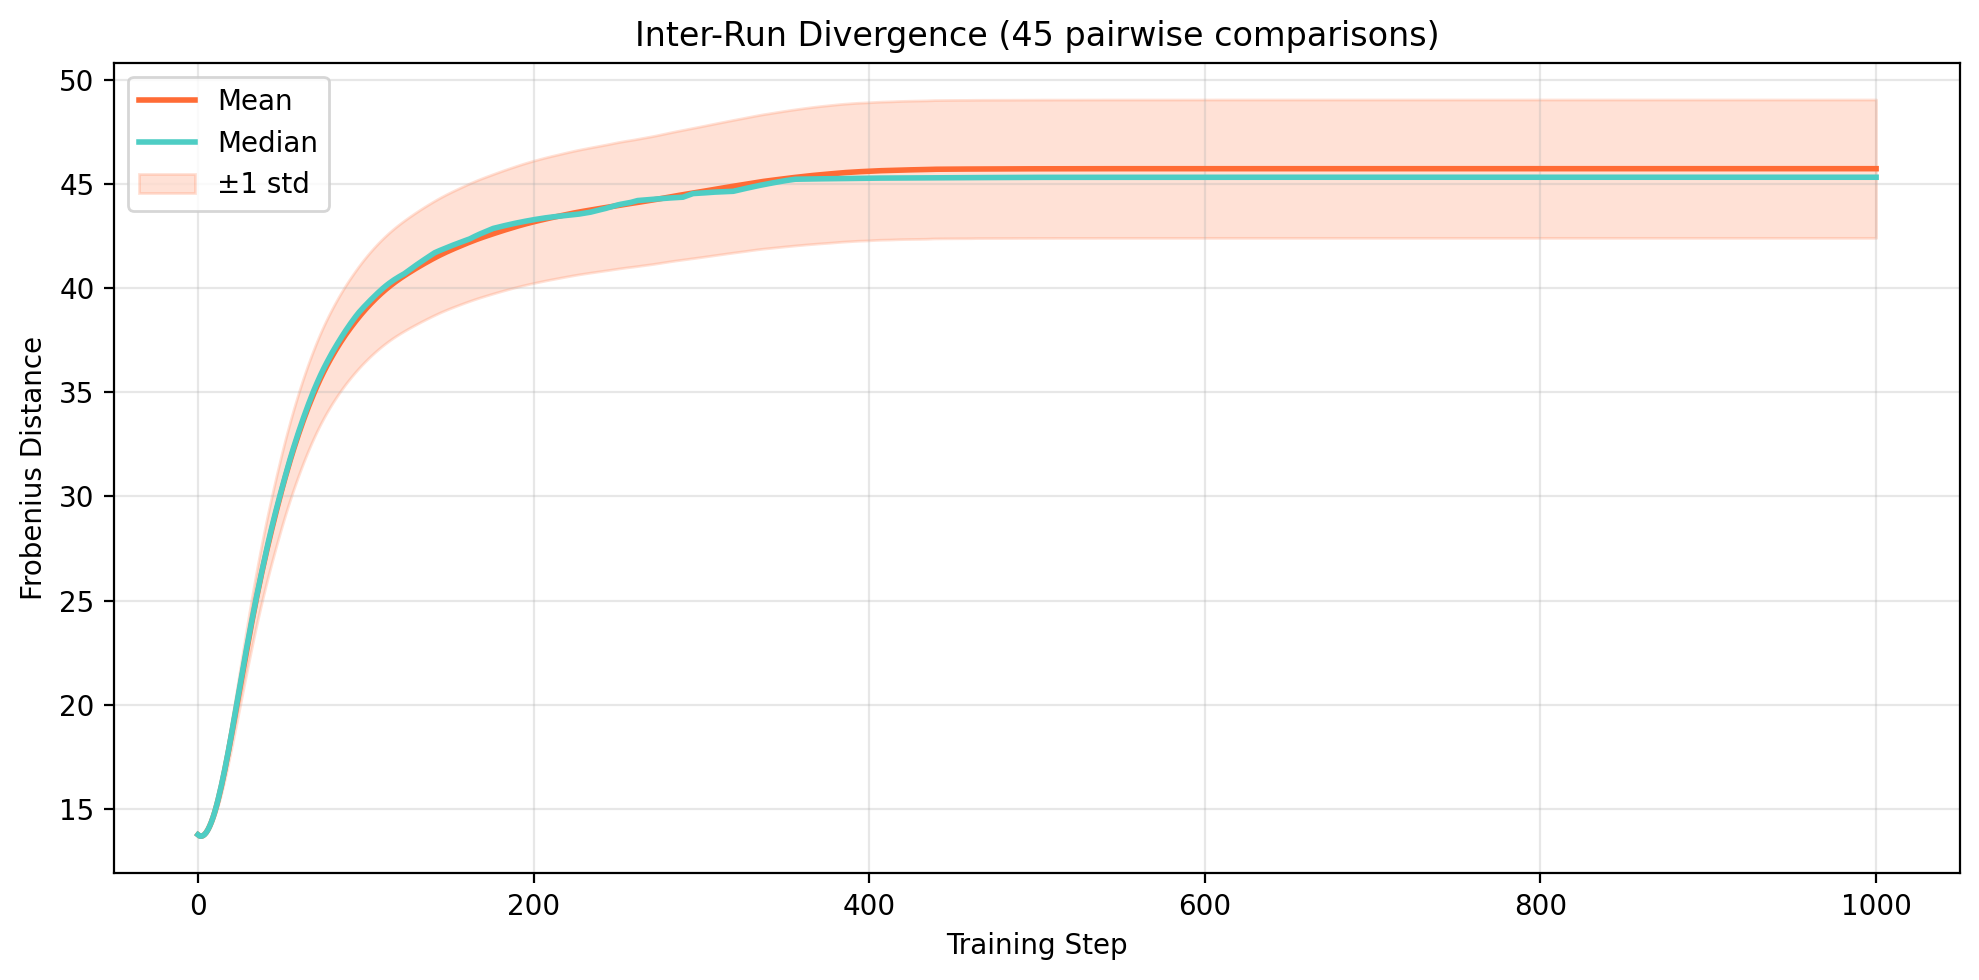

In [7]:
# Plot pairwise distances over time
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

ax.plot(frob_mean.numpy(), linewidth=2, color='#FF6B35', label='Mean', zorder=3)
ax.plot(frob_median.numpy(), linewidth=2, color='#4ECDC4', label='Median', zorder=3)
ax.fill_between(range(n_steps), 
                 (frob_mean - frob_std).numpy(), 
                 (frob_mean + frob_std).numpy(), 
                 alpha=0.2, color='#FF6B35', label='±1 std')

ax.set_xlabel('Training Step')
ax.set_ylabel('Frobenius Distance')
ax.set_title(f'Inter-Run Divergence ({n_pairs} pairwise comparisons)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Intra-Run Evolution

How far does each run travel from its own initialization?

$$||W_i(t) - W_i(0)||_F$$

In [8]:
# Compute distance from t=0 for each run
# Shape: (n_runs, n_steps)
evolution_distance = torch.zeros(n_runs, n_steps)

for i in range(n_runs):
    W_init = W_dead[i, 0]
    for t in range(n_steps):
        diff = W_dead[i, t] - W_init
        evolution_distance[i, t] = torch.norm(diff, p='fro')

print(f"✓ Computed evolution distance for {n_runs} runs")

✓ Computed evolution distance for 10 runs


In [9]:
# Summary statistics
evol_mean = evolution_distance.mean(dim=0)
evol_median = evolution_distance.median(dim=0)[0]
evol_std = evolution_distance.std(dim=0)

print(f"Evolution from initialization:")
print(f"  At t=1000:")
print(f"    Mean distance traveled: {evol_mean[-1]:.6f}")
print(f"    Median:                 {evol_median[-1]:.6f}")
print(f"    Std across runs:        {evol_std[-1]:.6f}")

Evolution from initialization:
  At t=1000:
    Mean distance traveled: 31.457407
    Median:                 30.704489
    Std across runs:        1.360466


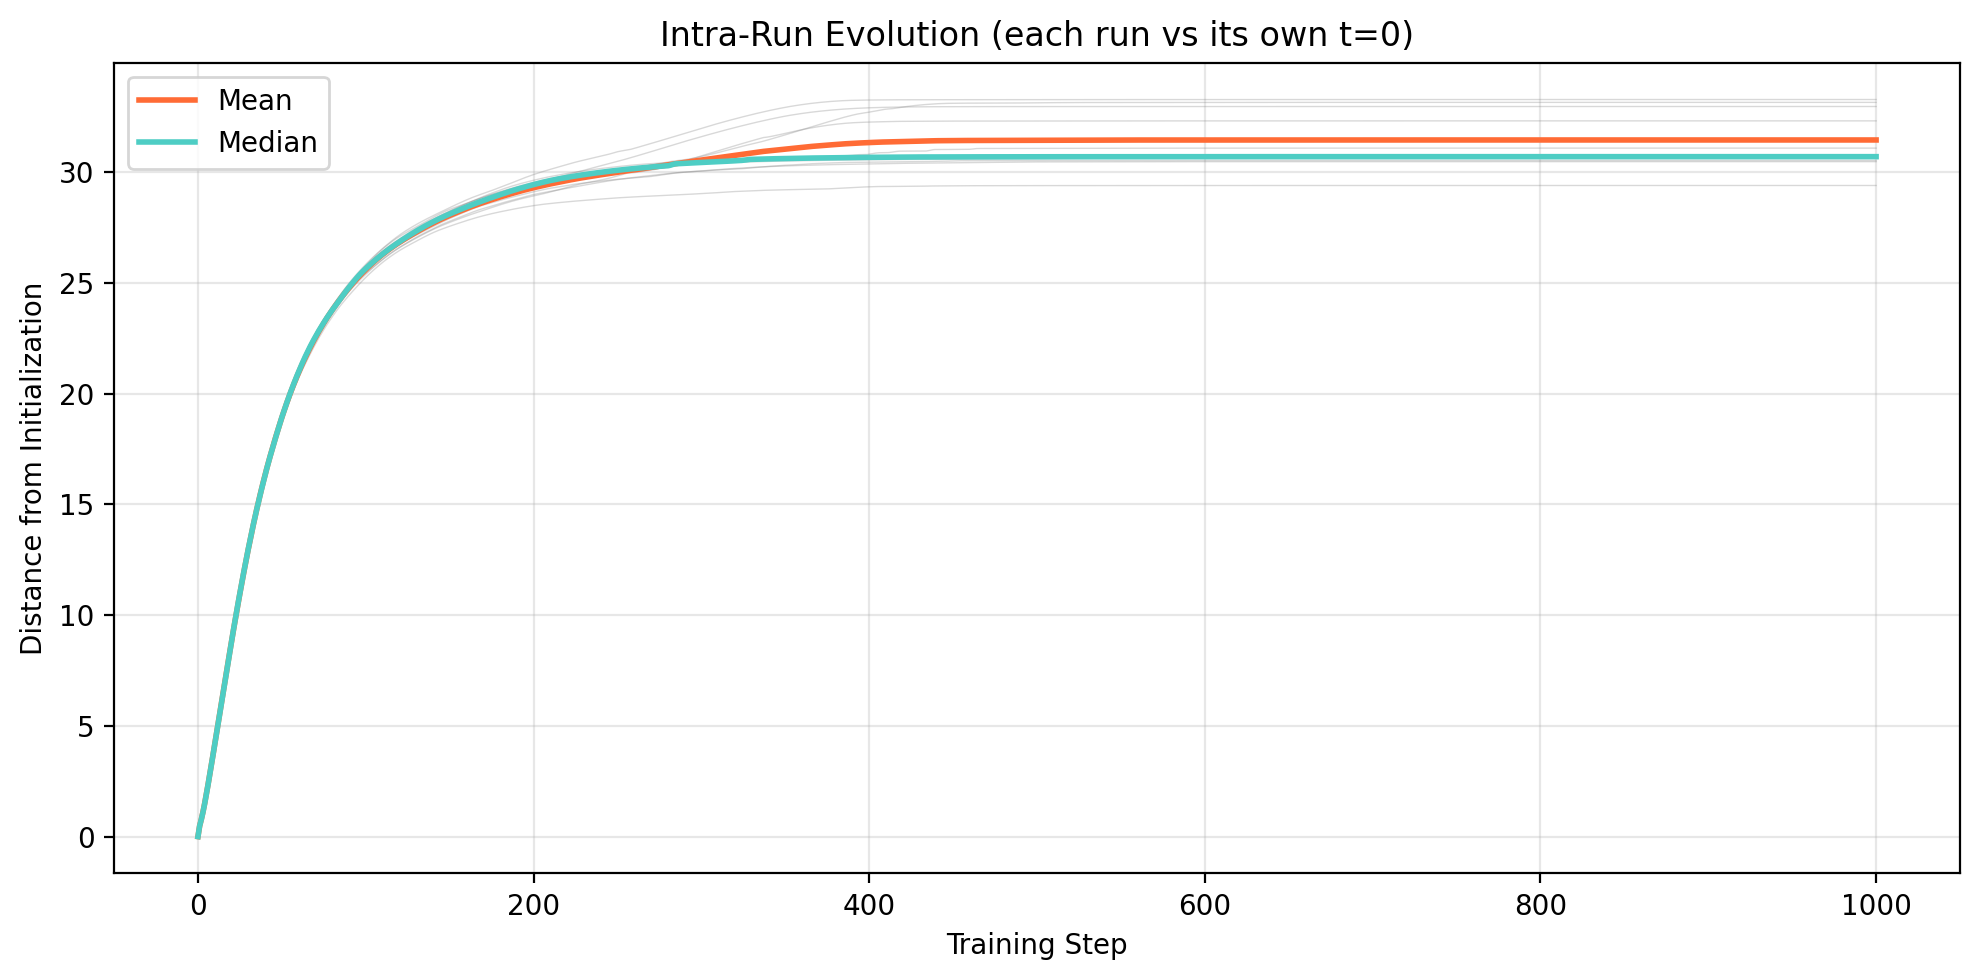

In [10]:
# Plot evolution distances
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot all 10 individual runs faintly
for i in range(n_runs):
    ax.plot(evolution_distance[i].numpy(), linewidth=0.5, alpha=0.3, color='gray')

# Plot mean and median prominently
ax.plot(evol_mean.numpy(), linewidth=2, color='#FF6B35', label='Mean', zorder=3)
ax.plot(evol_median.numpy(), linewidth=2, color='#4ECDC4', label='Median', zorder=3)

ax.set_xlabel('Training Step')
ax.set_ylabel('Distance from Initialization')
ax.set_title('Intra-Run Evolution (each run vs its own t=0)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Divergence vs Evolution Ratio

Compare inter-run divergence to intra-run evolution:

$$\text{Ratio}(t) = \frac{\text{mean pairwise distance}(t)}{\text{mean evolution distance}(t)}$$

- **Ratio ≪ 1**: Runs are much closer to each other than to their initializations → highly reproducible
- **Ratio ≈ 1**: Inter-run differences comparable to evolution → moderate divergence
- **Ratio ≫ 1**: Runs far apart relative to evolution → high divergence, different stories

In [11]:
# Compute ratio (avoid division by zero at t=0)
ratio = frob_mean / (evol_mean + 1e-10)

print(f"Divergence/Evolution ratio:")
print(f"  At t=10:    {ratio[10]:.4f}")
print(f"  At t=100:   {ratio[100]:.4f}")
print(f"  At t=500:   {ratio[500]:.4f}")
print(f"  At t=1000:  {ratio[-1]:.4f}")

Divergence/Evolution ratio:
  At t=10:    3.5680
  At t=100:   1.5227
  At t=500:   1.4539
  At t=1000:  1.4536


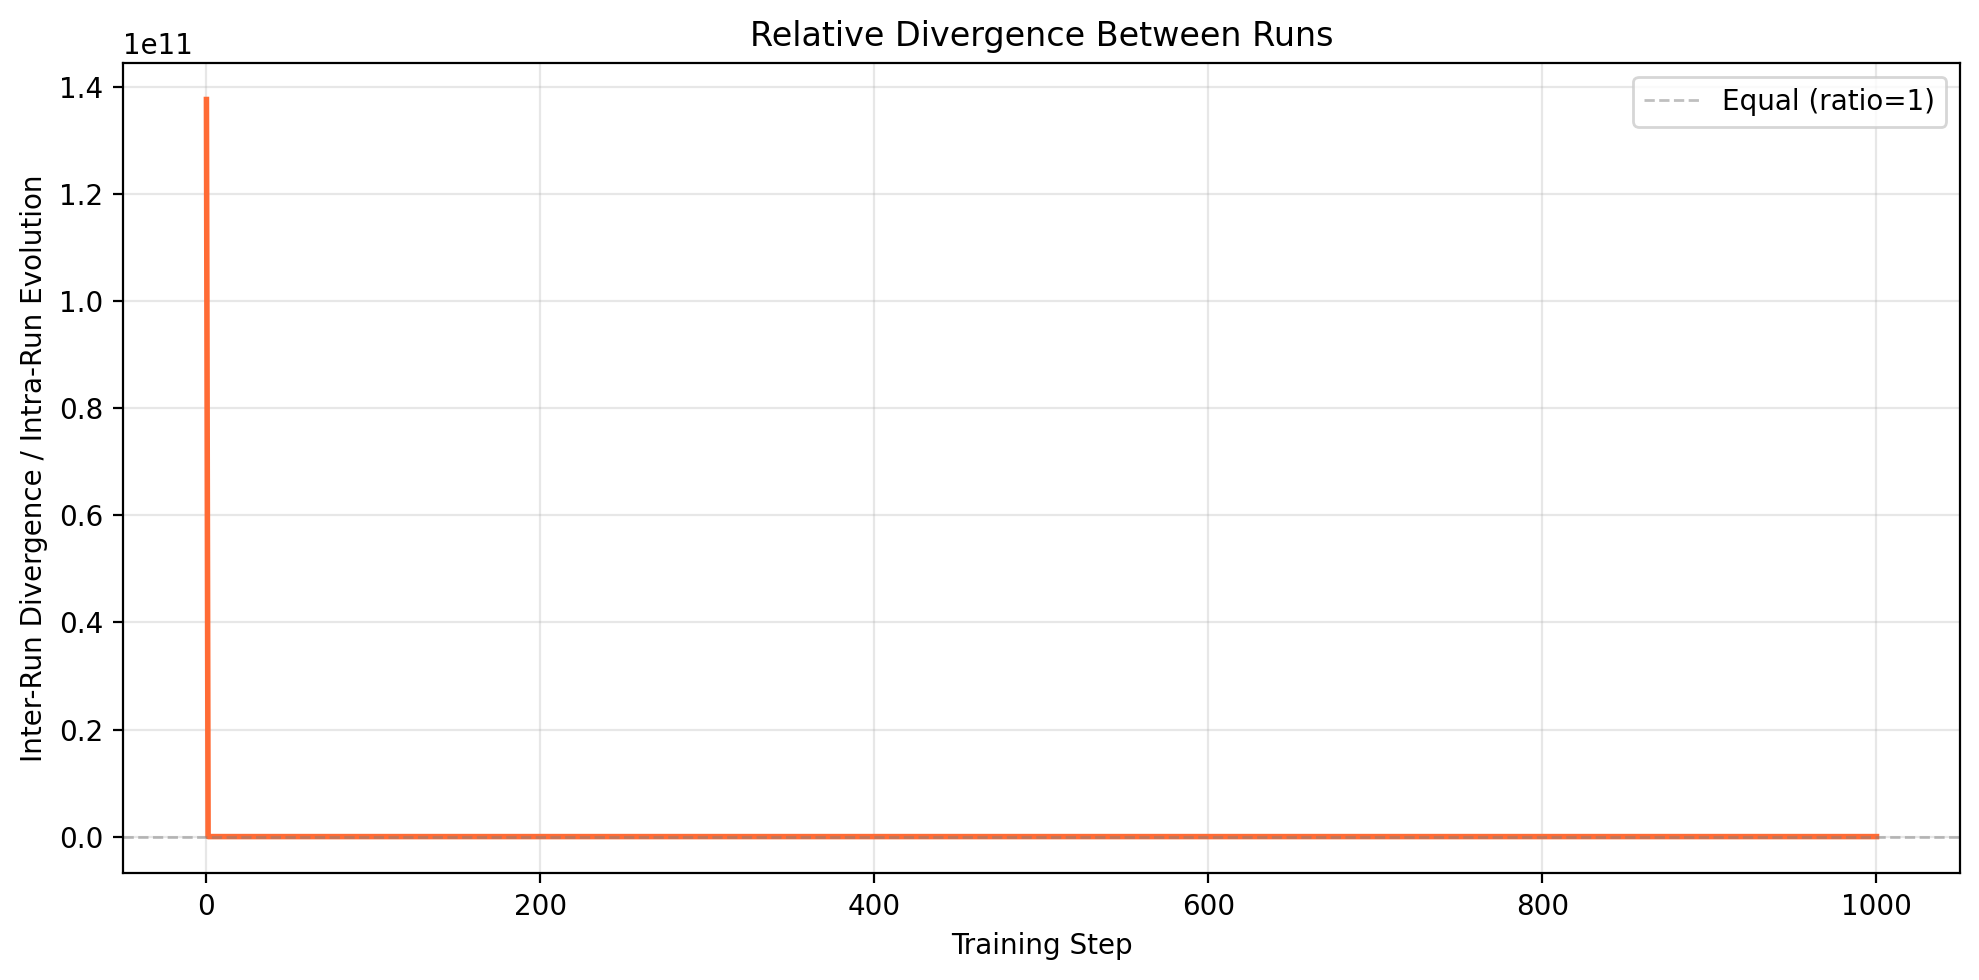

In [12]:
# Plot ratio over time
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

ax.plot(ratio.numpy(), linewidth=2, color='#FF6B35')
ax.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Equal (ratio=1)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Inter-Run Divergence / Intra-Run Evolution')
ax.set_title('Relative Divergence Between Runs')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Initial Divergence Check

The runs should be identical at t=0 (same initialization, modulo random seed for different tokens). Let's verify the initial pairwise distances are actually zero (or very close).

In [13]:
# Check t=0 distances
initial_distances = pairwise_frob[0]

print(f"Initial pairwise distances (t=0):")
print(f"  Mean:   {initial_distances.mean():.10f}")
print(f"  Median: {initial_distances.median():.10f}")
print(f"  Max:    {initial_distances.max():.10f}")
print()

if initial_distances.max() < 1e-6:
    print("✓ All runs start from essentially identical positions (within numerical precision)")
elif initial_distances.max() < 1:
    print("⚠ Small but non-zero initial differences (different random initializations per run)")
else:
    print("⚠ WARNING: Large initial differences! Runs may not have same initialization.")

Initial pairwise distances (t=0):
  Mean:   13.7653617859
  Median: 13.7634420395
  Max:    13.8150949478

⚠ WARNING: Large initial differences! Runs may not have same initialization.


## Growth Rate of Divergence

How fast does inter-run divergence grow?

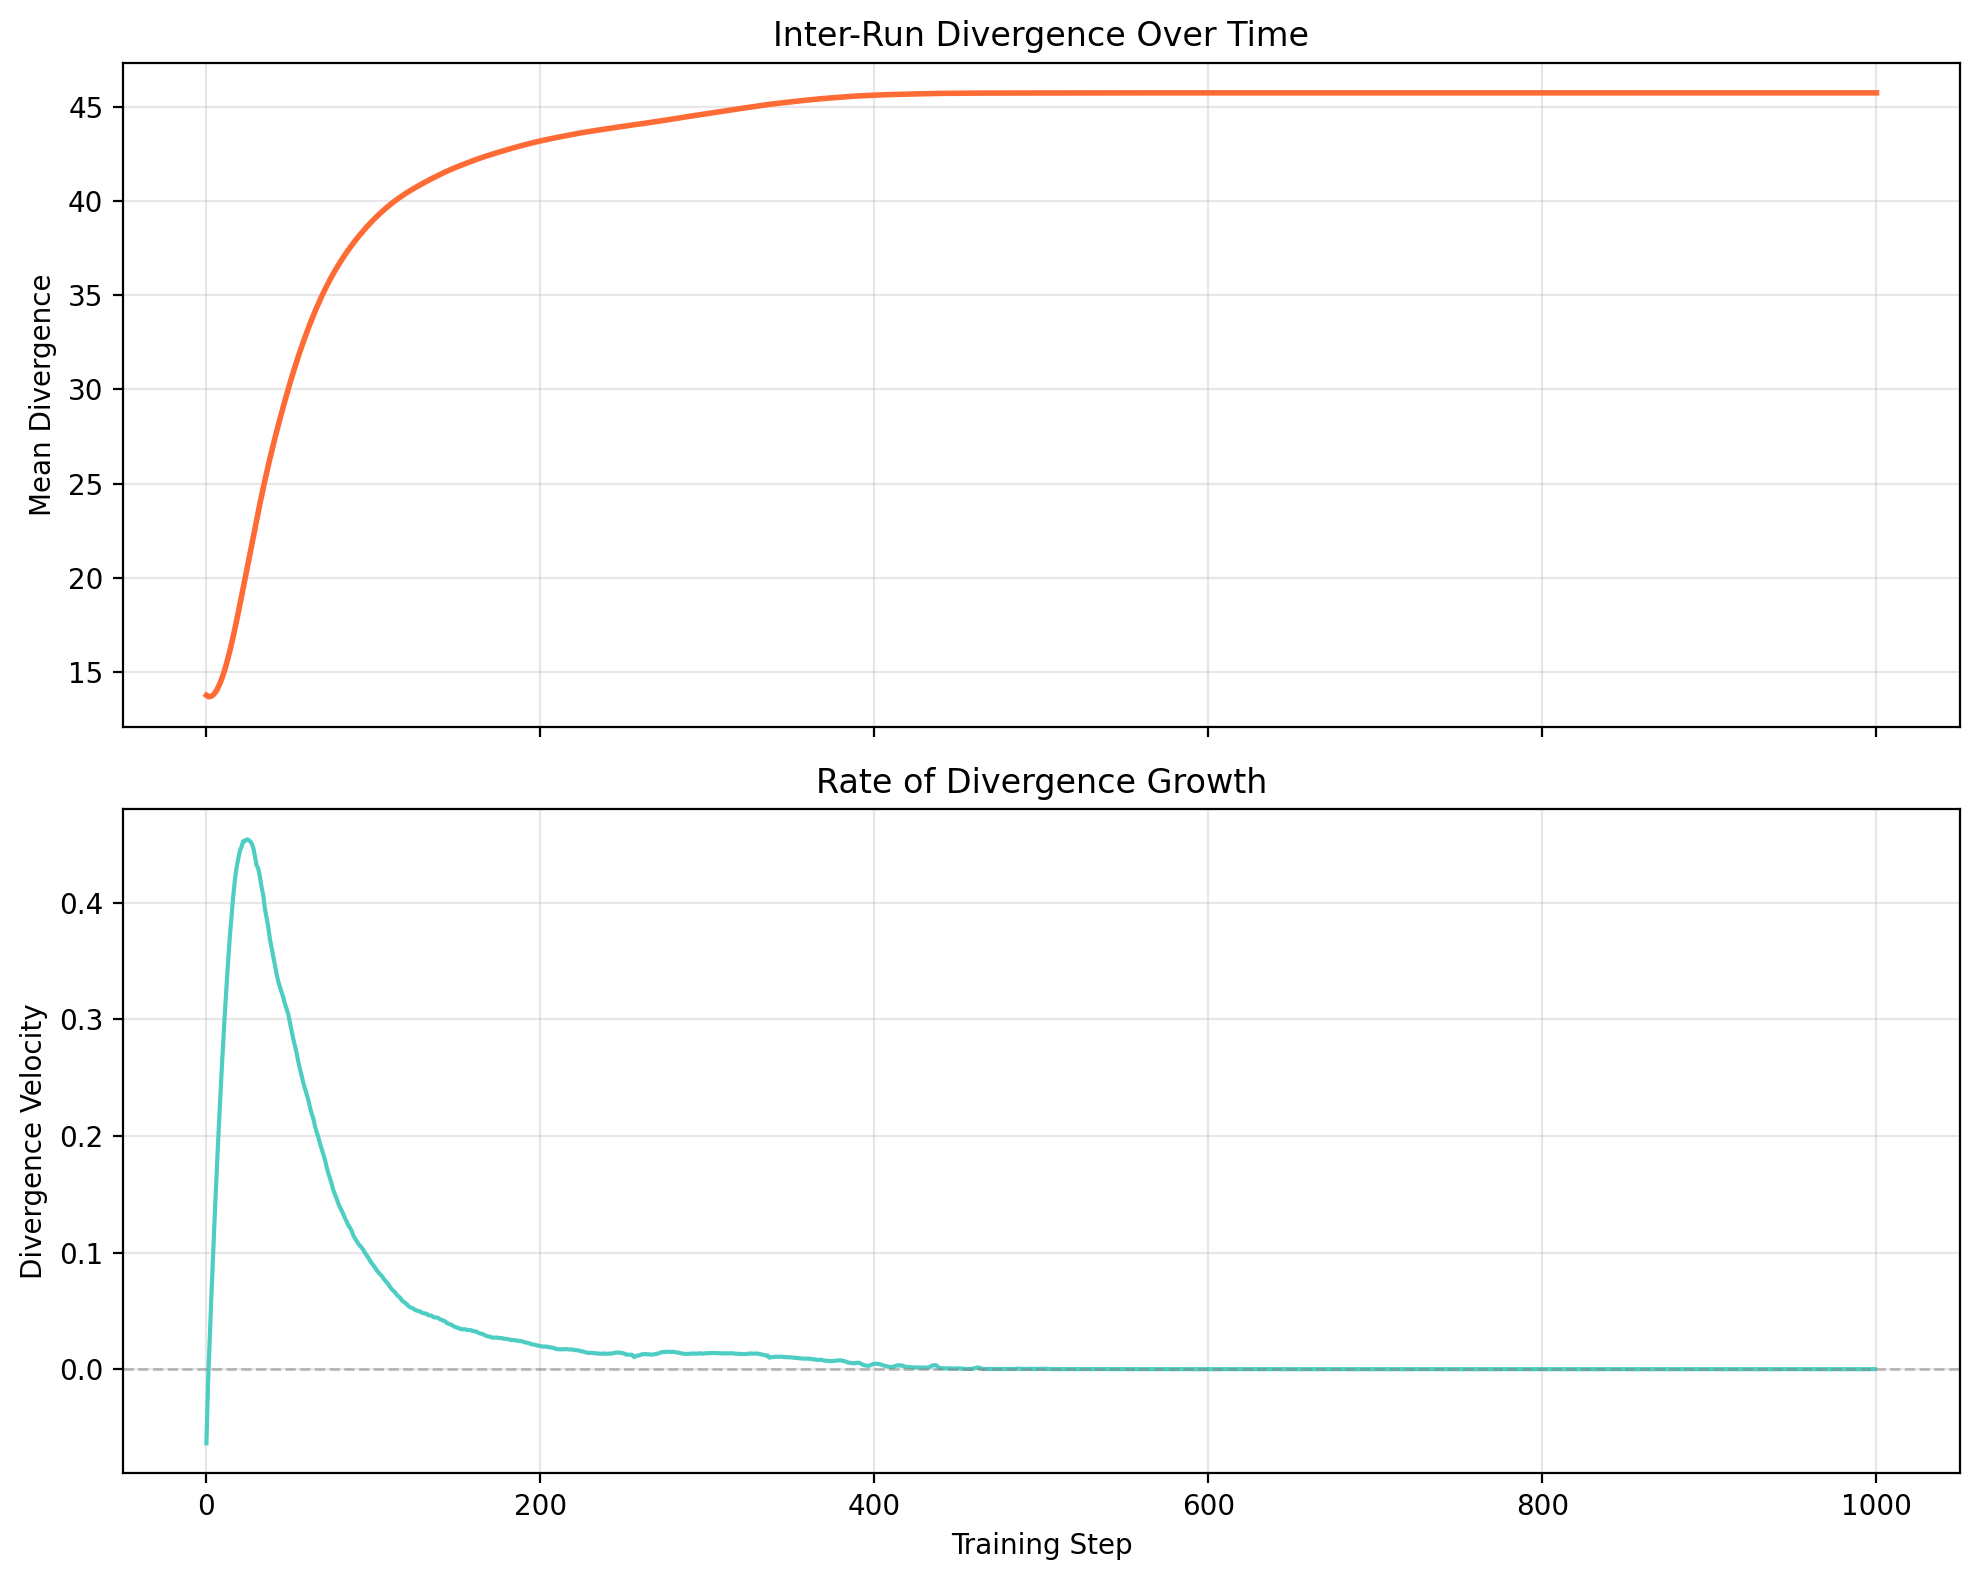

In [14]:
# Compute rate of change of mean divergence
divergence_velocity = torch.diff(frob_mean)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=DPI, sharex=True)

# Panel 1: Divergence
ax1.plot(frob_mean.numpy(), linewidth=2, color='#FF6B35')
ax1.set_ylabel('Mean Divergence')
ax1.set_title('Inter-Run Divergence Over Time')
ax1.grid(True, alpha=0.3)

# Panel 2: Rate of divergence
ax2.plot(divergence_velocity.numpy(), linewidth=1.5, color='#4ECDC4')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Divergence Velocity')
ax2.set_title('Rate of Divergence Growth')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [15]:
print("=" * 70)
print("RUN DIVERGENCE SUMMARY")
print("=" * 70)
print()

print(f"INITIAL STATE (t=0):")
print(f"  Max pairwise distance:        {initial_distances.max():.10f}")
print(f"  (Should be ~0 for identical initialization)")
print()

print(f"FINAL STATE (t=1000):")
print(f"  Mean inter-run divergence:    {frob_mean[-1]:.6f}")
print(f"  Mean intra-run evolution:     {evol_mean[-1]:.6f}")
print(f"  Divergence/Evolution ratio:   {ratio[-1]:.4f}")
print()

print(f"INTERPRETATION:")
if ratio[-1] < 0.1:
    print(f"  → Runs are HIGHLY REPRODUCIBLE")
    print(f"  → Inter-run differences are {ratio[-1]*100:.1f}% of evolution magnitude")
    print(f"  → Averaging/pooling across runs is appropriate")
elif ratio[-1] < 0.5:
    print(f"  → Runs are MOSTLY REPRODUCIBLE")
    print(f"  → Inter-run differences are {ratio[-1]*100:.1f}% of evolution magnitude")
    print(f"  → Averaging is reasonable, but variance should be reported")
elif ratio[-1] < 1.0:
    print(f"  → Runs show MODERATE DIVERGENCE")
    print(f"  → Inter-run differences are {ratio[-1]*100:.1f}% of evolution magnitude")
    print(f"  → Use median instead of mean; report full distribution")
else:
    print(f"  → Runs show HIGH DIVERGENCE")
    print(f"  → Inter-run differences are {ratio[-1]*100:.1f}% of evolution magnitude")
    print(f"  → Runs tell different stories; analyze distribution, not average")

print()
print(f"DIVERGENCE GROWTH:")
print(f"  Initial velocity (t=1):       {divergence_velocity[1]:.6f}")
print(f"  Peak velocity:                {divergence_velocity.max():.6f} at t={divergence_velocity.argmax().item()}")
print(f"  Final velocity (t=999→1000):  {divergence_velocity[-1]:.6f}")
print()
print("=" * 70)

RUN DIVERGENCE SUMMARY

INITIAL STATE (t=0):
  Max pairwise distance:        13.8150949478
  (Should be ~0 for identical initialization)

FINAL STATE (t=1000):
  Mean inter-run divergence:    45.727581
  Mean intra-run evolution:     31.457407
  Divergence/Evolution ratio:   1.4536

INTERPRETATION:
  → Runs show HIGH DIVERGENCE
  → Inter-run differences are 145.4% of evolution magnitude
  → Runs tell different stories; analyze distribution, not average

DIVERGENCE GROWTH:
  Initial velocity (t=1):       -0.010064
  Peak velocity:                0.454153 at t=24
  Final velocity (t=999→1000):  0.000000

